# Dog Vs Cat: A CNN based Dog/Cat Classifer 

## Enviroment Setup

In [1]:
import numpy as np
import pandas as pd
import os
import glob
import cv2
from collections import Counter
import random

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dropout, ELU
from keras.layers.convolutional import Cropping2D, Convolution2D, MaxPooling2D
from keras.layers.core import Lambda, Dense, Activation, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping 



from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19

import logging

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 5.0)

import seaborn as sns
sns.set(style="white", color_codes=True)





Using TensorFlow backend.


## Global Variables Initialazation

In [2]:
TRAIN_DATA_PATH_LIST = ["./train"]

IMAGE_INPUT_SHAPE = (224, 224, 3)

LABEL_LIST = sorted(["dog", "cat"])

DO_VISUALIZE = True
RUN_HOMEBREW_MODEL = False

logger = logging.getLogger("DogVsCat")  
logger.setLevel(logging.DEBUG) 
logging.basicConfig(level=logging.DEBUG,
                filename='DogCat.log',
                filemode='w')

# Load, Analysis, Visualize and Encode Data

* load raw datas
* transform image string labels to one-hot encoding
* visualize data

loading data from: ./train
total 12500 cat images loaded.
total 12500 dog images loaded.
total 25000 raw data samples loaded.


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


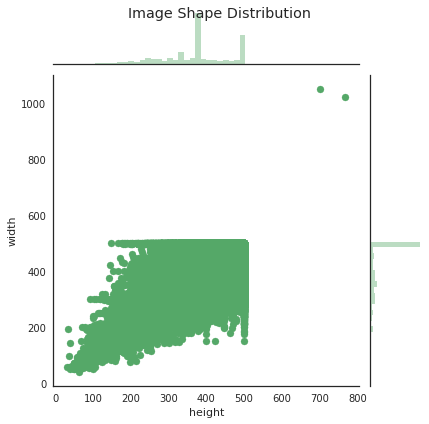

In [3]:
def label_one_hot_encoding(labe_list):
    encoder = LabelEncoder()
    transfomed_label = encoder.fit_transform(labe_list)
    one_hot_encoded_labels =  np_utils.to_categorical(transfomed_label)
    one_hot_label_dict = {}
    for i  in range(len(labe_list)):
        one_hot_label_dict[labe_list[i]] = one_hot_encoded_labels[i] 
    
    #inverse the label -> one-hot enchoding 1 to 1 map, turn list to tuple as the key
    inverse_one_hot_encoding_dict = {tuple(v): k for k, v in one_hot_label_dict.items()} 
    
    logger.info("one hot encoding for labels: ", one_hot_label_dict)
    logger.info(one_hot_label_dict)
    return one_hot_label_dict, inverse_one_hot_encoding_dict
    



def load_samples(DATA_PATH, one_hot_encoding_dict):
    """
    read all original data to a list, the element in the list is [one_hot_label, image_path]
    return value is the list
    """
    labels = one_hot_encoding_dict.keys()    
    samples = [] # format: [one_hot_label, image_path]
    temp_size = 0
    for dir in DATA_PATH: 
        print("loading data from: " + dir)
        for key in labels:           
            samples += [[one_hot_encoding_dict[key],file] for file in glob.glob(os.path.join(dir, key + '*.jpg'))]
            temp_size = len(samples) - temp_size    
            print("total " + str(temp_size) + " " + key + " images loaded.")
            logger.info("total " + str(temp_size) + " " + key + " images loaded.")
            temp_size = len(samples)
        
        print("total " + str(temp_size) + " raw data samples loaded.")
        logger.info("total " + str(temp_size) + " raw data samples loaded.")
        
    return samples    





    




def image_dimension_analysis(raw_sample_list, one_hot_encoding_dict, inverse_one_hot_encoding_dict):
    """
    image width，height and aspect ratio counter, return value is a dict    
    """   
    labels = one_hot_encoding_dict.keys()
   
    label_list,image_path_list, width_list, height_list, aspect_ratio_list = [], [], [], [], []
    for sample in raw_sample_list:
        label = inverse_one_hot_encoding_dict[tuple(sample[0])]       
        label_list.append(label)
        image_path_list.append(sample[1])
        
        image = cv2.imread(sample[1])
        
        height_list.append(image.shape[0])
        width_list.append(image.shape[1])
        aspect_ratio_list.append(np.float(image.shape[1]/image.shape[0]))


    df = pd.DataFrame({
        "label": label_list, 
        "image_path": image_path_list, 
        "height": height_list, 
        "width": width_list, 
        "aspect_ratio": aspect_ratio_list
    })
    
    image_shape_plot = sns.jointplot(x="height", y="width", data=df, stat_func=None, kind="scatter",color="g")
    sns.plt.suptitle('Image Shape Distribution')
    #fig = image_shape_plot.get_figure()
    image_shape_plot.savefig("./resource/image_shape_distribution.png")
    return df
    






    
one_hot_encoding_dict, inverse_one_hot_encoding_dict = label_one_hot_encoding(LABEL_LIST)

raw_samples = load_samples(TRAIN_DATA_PATH_LIST, one_hot_encoding_dict)

image_info_df =  image_dimension_analysis(raw_samples, one_hot_encoding_dict, inverse_one_hot_encoding_dict)







## Visualize Regular and Irregular Images

from the analysis above, we found most of image's width/height is within (200, 500), but there're also some images with large size. It's better to take a look at the irregular images.

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


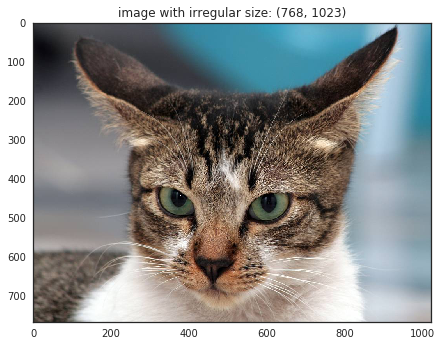

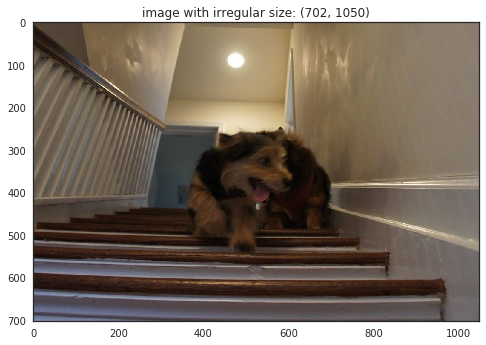

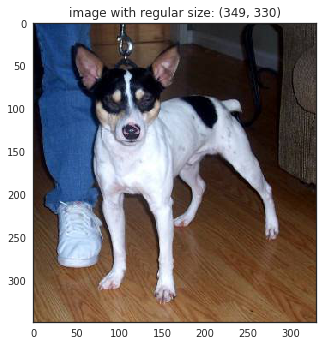

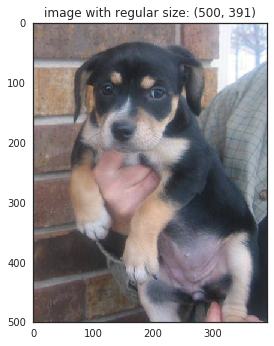

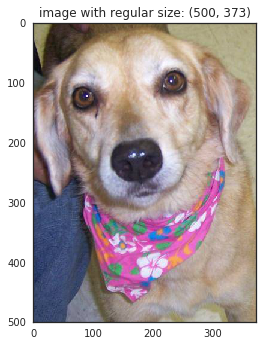

In [4]:
# visualize the irregular images
for i, row in image_info_df[image_info_df["width"] > 600].iterrows():
    #print(row)
    image = cv2.cvtColor(cv2.imread(row["image_path"]), cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title("image with irregular size: " +str(image.shape[:-1]))
    plt.show()
    
# visualize some regular image samples to compare
for i, row in image_info_df[image_info_df["width"] <  450].sample(3).iterrows():
    image = cv2.cvtColor(cv2.imread(row["image_path"]), cv2.COLOR_BGR2RGB)
    plt.title("image with regular size: " +str(image.shape[:-1]))
    plt.imshow(image)
    plt.show()
    

## Image Resize Helper Function

In [5]:
def resize_image(image, output_shape = (100, 100, 3)):
    """
    resize image to proper shape, the color channel will not be touched
    """      
    shape = (output_shape[0], output_shape[1])    
    resized_image = cv2.resize(image, shape)
    return resized_image


    

    

## Functions to Setup Model From Scratch

In [6]:
def homebrew_model_setup(input_shape = (224, 224, 3) , num_classes = 2):    
    """
    homebrew base model
    """     
    model = Sequential()    
    
    model.add(Lambda(lambda x: x/127.5 -1., input_shape = input_shape))
    model.add(Convolution2D(64,3,3)) #(32,3,3)
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Convolution2D(32,3,3))  #(32,3,3)  
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Convolution2D(32,3,3))  #(32,3,3)      
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))    
    
    model.add(Flatten())
    model.add(Dense(16))
    model.add(Activation('relu'))
    #model.add(Dropout(0.5))    
    model.add(Dense(num_classes))
    model.add(Activation("softmax"))

    print(model.summary())
    model.compile(loss = 'categorical_crossentropy',  optimizer = "rmsprop" , metrics = ['accuracy'])
    
    return model 


homebrew_model =  homebrew_model_setup(input_shape = (224, 224, 3) , num_classes = 2)       



____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 224, 224, 3)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 222, 222, 64)  1792        lambda_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 222, 222, 64)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 111, 111, 64)  0           activation_1[0][0]               
___________________________________________________________________________________________

## Functions to Setup Model from Pre-trainned Model 

In [7]:
def create_model_from_pretrained_model(input_shape = (224, 224, 3) , num_classes = 2, pre_trained_model_list = ["ResNet"]):
    """
    create models based on pre-trainned model's front end
    """   
    
    model_dict = {}
    
    for model_type in pre_trained_model_list:
        pre_trained_model = model_type(weights='imagenet', input_shape = input_shape, include_top = False)       
        for layer in pre_trained_model.layers:
            layer.trainable = False  # freeze the front-end weight of pre-trained model weight
            
        print("load pre-trainned model weight: " + model_type.__name__)
        

        
        # add back-end for current problem 
        x = pre_trained_model.output       
        x = Flatten(name='flatten')(x)        
        x = Dense(256, activation = "relu", name="fc256") (x)        
        x = Dense(64, activation = "relu", name="fc64") (x)
        x = Dropout(0.5) (x)    
        x = Dense(num_classes, name="fc_output") (x)
        predictions =  Activation('softmax') (x)
        
        model = Model(input = pre_trained_model.input,  output=predictions)
        model.compile(loss = 'categorical_crossentropy',  optimizer = "rmsprop" , metrics = ['accuracy'])
        
        print(model_type)
        print(model.summary())
        model_dict[model_type.__name__] = model
    
    return model_dict


model_dict =  create_model_from_pretrained_model(num_classes = 2, pre_trained_model_list = [VGG16,VGG19,ResNet50])

print(model_dict)

load pre-trainned model weight: VGG16
<function VGG16 at 0x7f3eab2f97b8>
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 224, 224, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 224, 224, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 112, 112, 64)  0           block1_conv2[0][0]               
__________________

## Image Sample Batch Generator for Model Training and Testing 

In [8]:
def sample_generator(samples, batch_size=10):
    
    while True:
        samples = shuffle(samples)
        num_samples = len(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset + batch_size]
            images = []
            one_hot_labels = []
            
            for sample in batch_samples:
                image = cv2.imread(sample[1])
                image = resize_image(image, output_shape = IMAGE_INPUT_SHAPE)

                images.append(image)
                one_hot_labels.append(sample[0])
                #plt.imshow(image)
                #plt.show()
            
            X_train = np.array(images)
            y_train = np.array(one_hot_labels)
            
            #print("y_train", y_train)
            yield shuffle(X_train, y_train)

    


## Model Fit History Visualization

In [9]:
def model_fit_history_visualization(history, name):        
        #  accuracy history
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.savefig("./resource/" + name + '_accuracy.png')
        plt.show()
        # loss history
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.savefig("./resource/" + name + '_loss.png')
        plt.show()

## Model Training Data Preparation

In [10]:
train_validation_samples, test_samples = train_test_split(raw_samples, test_size = 0.2, random_state = 42)
train_samples, validation_samples = train_test_split(train_validation_samples, test_size = 0.2, random_state = 42)
print("train sample count: ", len(train_samples), "\nvalidation sample count: ", len(validation_samples), "\ntest sample count: ", len(test_samples))
    
    
train_generator = sample_generator(train_samples, batch_size = 100)
validation_generator = sample_generator(validation_samples, batch_size = 100)
test_generator = sample_generator(test_samples, batch_size = 100)


 

train sample count:  16000 
validation sample count:  4000 
test sample count:  5000


##  1st Model Training Flow

models:
{'VGG16': <keras.engine.training.Model object at 0x7f3ea40c5d68>, 'homebrew': <keras.models.Sequential object at 0x7f3ea850d320>, 'ResNet50': <keras.engine.training.Model object at 0x7f3e97d7f208>, 'VGG19': <keras.engine.training.Model object at 0x7f3e9ecda2b0>}
ResNet50 start fitting...
Epoch 1/50
16000/16000 [==============================] - 197s - loss: 0.1980 - acc: 0.9290 - val_loss: 0.0504 - val_acc: 0.9783

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


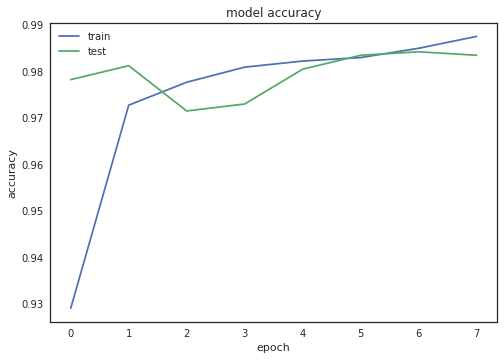

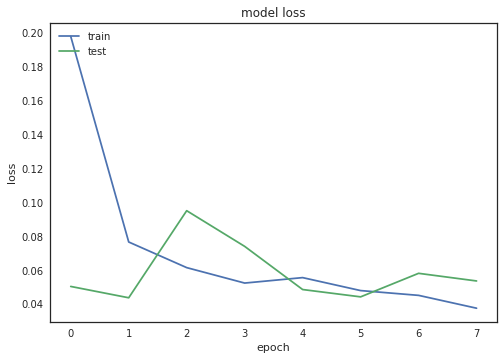

ResNet50test categorical crossentropy: 0.0537791348683 test accuracy: 0.985333339373
model ResNet50 is saved.
VGG16 start fitting...
Epoch 1/50
16000/16000 [==============================] - 311s - loss: 2.1821 - acc: 0.8613 - val_loss: 0.9612 - val_acc: 0.9380

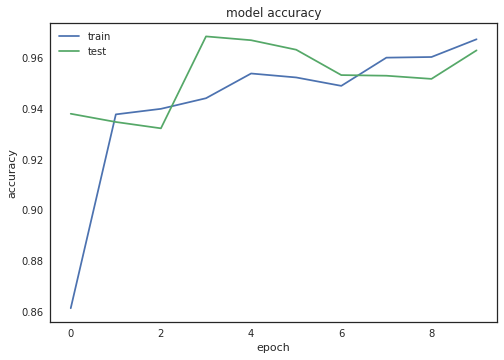

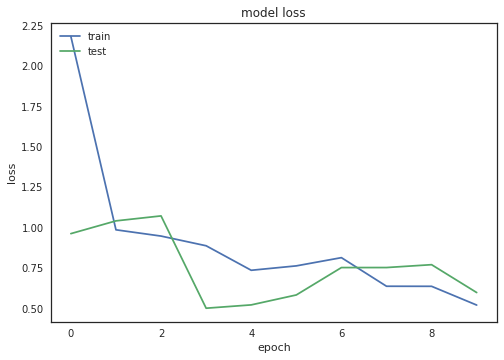

VGG16test categorical crossentropy: 0.623233075937 test accuracy: 0.96133333842
model VGG16 is saved.
VGG19 start fitting...
Epoch 1/50
16000/16000 [==============================] - 360s - loss: 1.6137 - acc: 0.8968 - val_loss: 0.6178 - val_acc: 0.9603

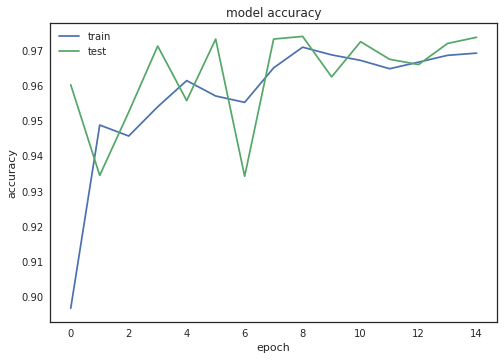

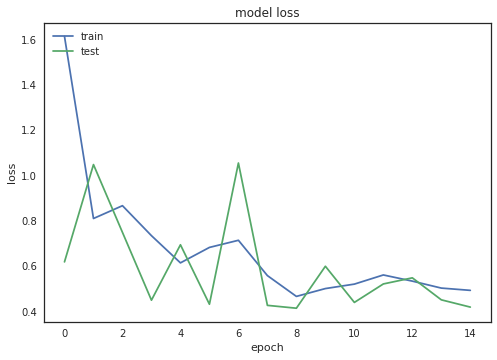

VGG19test categorical crossentropy: 0.387001304825 test accuracy: 0.976000018915
model VGG19 is saved.
homebrew start fitting...
Epoch 1/50
16000/16000 [==============================] - 96s - loss: 0.6816 - acc: 0.6200 - val_loss: 0.6482 - val_acc: 0.6697

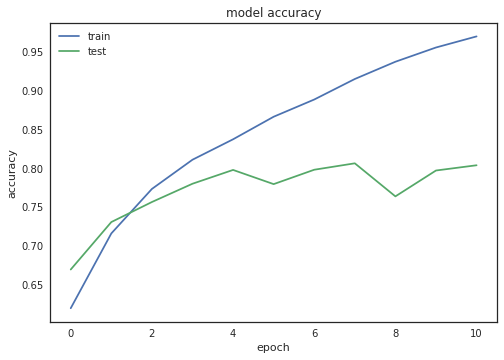

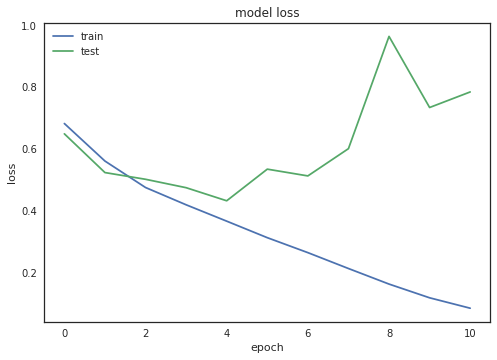

homebrewtest categorical crossentropy: 0.836917797724 test accuracy: 0.788666653633
model homebrew is saved.


In [11]:
model_dict["homebrew"] = homebrew_model
print("models:")
print(model_dict)

num_epochs = 50

early_stop_callback = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=0, mode='auto')

for model_name in sorted(model_dict.keys()):
    model = model_dict[model_name]            
    print(model_name + " start fitting...")
    history_object = model.fit_generator(train_generator, samples_per_epoch= int(len(train_samples)), 
                                         validation_data=validation_generator, nb_val_samples=len(validation_samples), 
                                         nb_epoch=num_epochs, verbose=1, callbacks = [early_stop_callback])
    model_fit_history_visualization(history_object, model_name)
    score = model.evaluate_generator(test_generator, 1500, max_q_size=10, nb_worker=1, pickle_safe=False)
    print(model_name + "test categorical crossentropy: "+ str(score[0]), "test accuracy: "+ str(score[1]))
    model.save("./models/" + model_name + ".h5" )
    print("model " + model_name + " is saved.")
    